# Testing CNN Shape Measurements of Simple Galaxy Models

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde, pearsonr

#tensorflow
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print("Tensorflow version: {}".format(tf.version.VERSION))

#keras only after gpu ID and memory usage is set
import tensorflow.keras.models as km
import tensorflow.keras.layers as kl
import tensorflow.keras.regularizers as kr
import tensorflow.keras.optimizers as ko

import tensorflow_datasets as tfds

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Tensorflow version: 2.7.0


## CNN Models

In [2]:
def Ribli19(imsize=50, n_target=2 ,n_channels=1, nf=64, reg = 5e-5,
          padding='same', gpu='0'):

    #input
    inp = kl.Input((imsize, imsize,n_channels))
    
    # conv block 1
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(inp)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 2
    x = kl.Conv2D(2*nf, (3, 3), padding=padding,kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 3
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(2*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)

    # conv block 4
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(4*nf, (1, 1), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    x = kl.MaxPooling2D(strides=(2,2))(x)
    
    # conv block 5
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(8*nf, (1, 1), padding=padding,  kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    x = kl.Conv2D(16*nf, (3, 3), padding=padding, kernel_regularizer=kr.l2(reg))(x)
    x = kl.Activation('relu')(kl.BatchNormalization()(x))
    
    #  end of conv
    
    x = kl.GlobalAveragePooling2D()(x)    
    x = kl.Dense(n_target)(x)#, name = 'final_dense_n%d_ngpu%d' % (n_target, len(gpu.split(','))))(x)  

    model = km.Model(inputs=inp, outputs=x)  # make model
       
    return model

In [3]:
from autometacal.python.datasets import GalGen

## Load Data

In [4]:
(datat, datav), ds_info = tfds.load('GalGen/small_stamp_100k',as_supervised=True,split=['train[:14%]', 'train[14%:20%]'],with_info=True)
datat = datat.cache()
datat = datat.shuffle(ds_info.splits['train'].num_examples)
datat = datat.batch(512)
datat = datat.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
datav = datav.cache()
datav = datav.batch(512)
datav = datav.prefetch(tf.data.experimental.AUTOTUNE)

In [6]:
data= tfds.load('GalGen/small_stamp_100k')
data = data['train'].cache()
data = data.batch(8)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [7]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

plt.style.use('default')
plt.figure(figsize=(10,10))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(gal_images[i])

## Generate Model

In [8]:
model = Ribli19(51,n_channels=1)

In [9]:
import autometacal as amc

## Create Loss Function

In [10]:
@tf.function
def loss(batch):
  #Apply shear here
  
  #compute response
  R = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],batch['psf_image'],0.01,model)[1]
  
  lost = tf.norm(R - tf.eye(2))
  
  return lost

Testing the loss function:

In [11]:
batch_size = 8
def step():
  with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    batch = batchit.next()
      
    with tf.GradientTape() as tape2:
      g = tf.zeros([batch_size, 2])
      tape2.watch(g)
      # Measure ellipticity under metacal
      e = model(amc.generate_mcal_image(batch['obs_image'],
                                     batch['psf_image'],
                                     batch['psf_image'],
                                     g))
      # Compute response matrix
      R = tape2.batch_jacobian(e, g)

  
    lost = tf.norm(R - tf.eye(2))
    
    print(lost)
  grads = tape.gradient(lost, model.trainable_variables)
  return grads


In [12]:
ko.SGD?

Init signature:
ko.SGD(
    learning_rate=0.01,
    momentum=0.0,
    nesterov=False,
    name='SGD',
    **kwargs,
)
Docstring:     
Gradient descent (with momentum) optimizer.

Update rule for parameter `w` with gradient `g` when `momentum` is 0:

```python
w = w - learning_rate * g
```

Update rule when `momentum` is larger than 0:

```python
velocity = momentum * velocity - learning_rate * g
w = w + velocity
```

When `nesterov=True`, this rule becomes:

```python
velocity = momentum * velocity - learning_rate * g
w = w + momentum * velocity - learning_rate * g
```

Args:
  learning_rate: A `Tensor`, floating point value, or a schedule that is a
    `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable
    that takes no arguments and returns the actual value to use. The
    learning rate. Defaults to 0.01.
  momentum: float hyperparameter >= 0 that accelerates gradient descent
    in the relevant
    direction and dampens oscillations. Defaults to 0, i.e., vanilla gra

In [13]:
opt = ko.SGD(learning_rate=0.005,nesterov=True)

### Test with finitediff

In [14]:
import tqdm

In [15]:
@tf.function
def loss_fd(batch,model):
  #Apply shear here
  
  #compute response
  R = amc.get_metacal_response_finitediff(batch['obs_image'],batch['psf_image'],batch['psf_image'],0.01,model)[1]
  
  lost = tf.norm(R - tf.eye(2))
  
  return lost

modelfd = Ribli19(51,n_channels=1)
def stepfd(batch):
  with tf.GradientTape() as tape:
    lost = loss_fd(batch,modelfd)
    grads = tape.gradient(lost, modelfd.trainable_variables)
    
  opt.apply_gradients(zip(grads, modelfd.trainable_variables))
  return lost




@tf.function
def loss_ad(batch,model):
  #Apply shear here
  
  #compute response
  R = amc.get_metacal_response(batch['obs_image'],batch['psf_image'],batch['psf_image'],model)[1]
  
  lost = tf.norm(R - tf.eye(2))
  
  return lost

modelad = Ribli19(51,n_channels=1)
def stepad(batch):
  with tf.GradientTape() as tape:
    lost = loss_ad(batch,modelad)
    grads = tape.gradient(lost, modelad.trainable_variables)
    
  opt.apply_gradients(zip(grads, modelad.trainable_variables))

  return lost
loistad= []
loistfd= []
for _ in tqdm.tqdm(range(4000)):
  batch = batchit.next()
  lostad=stepad(batch)
  loistad.append(lostad)
  lostfd=stepfd(batch)
  loistfd.append(lostfd)


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [15:45<00:00,  4.23it/s]


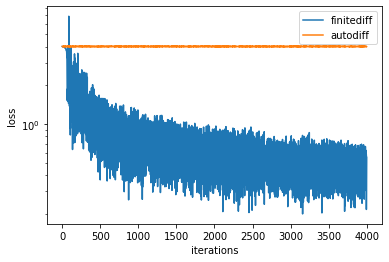

In [18]:
plt.plot(range(4000),loistfd,label='finitediff')
plt.plot(range(4000),loistad,label='autodiff')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.savefig('learning3.png',bbox_inches='tight')

### New test with autodiff

In [52]:


modelad = Ribli19(51,n_channels=1)

@tf.function
def get_metacal_response_NN(gal_images,
                         psf_images,
                         reconvolution_psf_image):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  reconvolution_psf_image = tf.convert_to_tensor(reconvolution_psf_image, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  g = tf.zeros([batch_size, 2])
  with tf.GradientTape() as tape:
    tape.watch(g)
    # Measure ellipticity under metacal
    e = modelad(amc.generate_mcal_image(gal_images,
                                   psf_images,
                                   reconvolution_psf_image,
                                   g))
    
  # Compute response matrix

  R = tape.batch_jacobian(e, g)
  return e, R

@tf.function
def loss_ad(batch):
  #Apply shear here
  
  #compute response
  R = get_metacal_response_NN(batch['obs_image'],batch['psf_image'],batch['psf_image'])[1]
  
  lost = tf.norm(R - tf.eye(2))
  
  return lost

@tf.function
def stepad(batch):
  with tf.GradientTape() as tape:
    tape.watch(modelad.trainable_variables)
    lost = get_metacal_response_NN(batch['obs_image'],batch['psf_image'],batch['psf_image'])[1]
  grads = tape.gradient(lost, modelad.trainable_variables)
  print(grads)  
  opt.apply_gradients(zip(grads, modelad.trainable_variables))


  

In [53]:
stepad(onebatch)

[<tf.Tensor 'PartitionedCall:3' shape=(3, 3, 1, 64) dtype=float32>, <tf.Tensor 'PartitionedCall:4' shape=(64,) dtype=float32>, <tf.Tensor 'PartitionedCall:5' shape=(64,) dtype=float32>, <tf.Tensor 'PartitionedCall:6' shape=(64,) dtype=float32>, <tf.Tensor 'PartitionedCall:7' shape=(3, 3, 64, 64) dtype=float32>, <tf.Tensor 'PartitionedCall:8' shape=(64,) dtype=float32>, <tf.Tensor 'PartitionedCall:9' shape=(64,) dtype=float32>, <tf.Tensor 'PartitionedCall:10' shape=(64,) dtype=float32>, <tf.Tensor 'PartitionedCall:11' shape=(3, 3, 64, 128) dtype=float32>, <tf.Tensor 'PartitionedCall:12' shape=(128,) dtype=float32>, <tf.Tensor 'PartitionedCall:13' shape=(128,) dtype=float32>, <tf.Tensor 'PartitionedCall:14' shape=(128,) dtype=float32>, <tf.Tensor 'PartitionedCall:15' shape=(3, 3, 128, 128) dtype=float32>, <tf.Tensor 'PartitionedCall:16' shape=(128,) dtype=float32>, <tf.Tensor 'PartitionedCall:17' shape=(128,) dtype=float32>, <tf.Tensor 'PartitionedCall:18' shape=(128,) dtype=float32>, <t

In [38]:
batchit = data.as_numpy_iterator()
loistad= []
for _ in tqdm.tqdm(range(4000)):
  batch = batchit.next()
  lostad=stepad(batch)
  loistad.append(lostad)

  2%|▏         | 80/4000 [00:03<02:48, 23.31it/s]


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (4000,) and (0,)

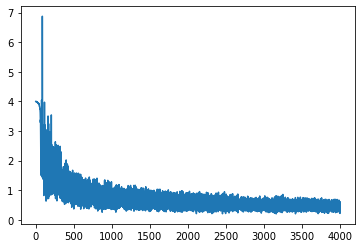

In [33]:
plt.plot(range(4000),loistfd,label='finitediff')
plt.plot(range(4000),loistad,label='autodiff')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.savefig('learning4.png',bbox_inches='tight')

In [36]:
loistad

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [17]:
banana();

NameError: name 'banana' is not defined

## Optimise Model

## Predict on Test Set

In [ ]:
test  = datav

#predictions
predictions = model.predict(test)

#labels
test_unb  = test.unbatch()
test_unb_it = test_unb.as_numpy_iterator()
listtest  = [next(test_unb_it) for i in range(len(predictions))]
labels = np.array([listtest[i][1] for i in range(len(predictions))])

## Plot the Results

In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,10))

#linear fit
poly_g1 = np.polyfit(labels[:,0],predictions[:,0],1)
poly_g2 = np.polyfit(labels[:,1],predictions[:,1],1)

#correlation coefficient
corr_g1 = pearsonr(labels[:,0],predictions[:,0])
corr_g2 = pearsonr(labels[:,1],predictions[:,1])

#plots
plt.scatter(labels[:,0],predictions[:,0]-labels[:,0],alpha=0.5,label='g1')
plt.scatter(labels[:,1],predictions[:,1]-labels[:,1],alpha=0.5,label='g2')

#text
plt.text(-.25,0.75, "$m_1$ = {:.2e},  $c_1$ = {:.2e}, r = {:.2e}".format(1-poly_g1[0],poly_g1[1],corr_g1[0]),fontsize=15)
plt.text(-.25,0.5 , "$m_2$ = {:.2e},  $c_2$ = {:.2e}, r = {:.2e}".format(1-poly_g2[0],poly_g2[1],corr_g2[0]),fontsize=15)

#zero
plt.plot([-1,1],[0,0],'k-')

#settings
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.title("Exponential Model, Noisy (SNR=80) , no PSF, CNN Test",fontsize=20)
plt.xlabel("True",fontsize=20)
plt.ylabel("Residuals",fontsize=20)
plt.legend(fontsize=20)

#save
plt.savefig("first_test.png",bbox_inches="tight")